In [1]:
import sys
print(sys.version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue import Sheet, SheetGeometry, Monolayer, config, MonoLayerGeometry
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.draw import sheet_view
from tyssue.io import hdf5

from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.dynamics import model_factory, effectors

from tyssue import collisions
from tyssue.collisions.solvers import CollisionSolver
from tyssue import version
print('tyssue version: ', version.full_version)


3.7.0 | packaged by conda-forge | (default, Nov 12 2018, 19:59:33) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
tyssue version:  0.2.4.dev0+80f45ef


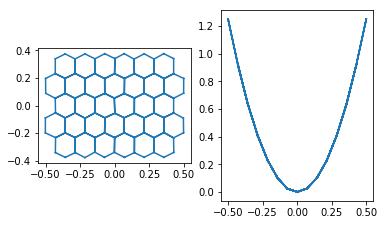

In [3]:

sheet = Sheet.planar_sheet_3d('crossed',
                              36, 12, 1, 1)
sheet.remove(sheet.cut_out([[5, 12], [0, 6]]))
sheet.sanitize()
SheetGeometry.center(sheet)
SheetGeometry.scale(sheet, 1/sheet.vert_df.x.ptp(), coords=list('xy'))

sheet.vert_df.z = 5 * sheet.vert_df.x**2
sheet.vert_df[sheet.coords] += np.random.normal(scale=0.001, size=(sheet.Nv, 3))
    

SheetGeometry.update_all(sheet)


fig, axes = plt.subplots(1, 2, sharex=True)
fig, ax = sheet_view(sheet, coords=['x', 'y'], mode='quick', ax=axes[0])
fig, ax = sheet_view(sheet, coords=['x', 'z'], mode='quick', ax=axes[1])



In [4]:
class Fold(effectors.AbstractEffector):
    
    magnitude = 'folding_force'
    element = 'vert'
    specs = {"vert": {'folding_force'}}
    
    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval('-folding_force * x')
    
    @staticmethod
    def gradient(eptm):
        grad = eptm.vert_df[eptm.coords].copy()
        grad.columns = ['gx', 'gy', 'gz']
        grad[["gy", "gz"]] = 0
        grad['gx'] = eptm.vert_df.eval('-folding_force')
        
        return grad, None
    
#model = model_factory([effectors.LineTension, effectors.FaceAreaElasticity, Fold],
#                      effectors.FaceAreaElasticity)
model = model_factory([Fold], Fold)


sheet.vert_df['folding_force'] = - 8e-3 * sheet.vert_df.x**3
sheet.edge_df['line_tension'] = 0.07
sheet.face_df['prefered_area'] = sheet.face_df.area.mean()
sheet.face_df['area_elasticity'] = 2.

sheet2 = sheet.copy()


In [5]:
res = Solver.find_energy_min(sheet, SheetGeometry, model)
ipv.clear()
fig, mesh = sheet_view(sheet, mode='3D')
fig

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/tyssue-0.2.4-py3.7-linux-x86_64.egg/tyssue/dynamics/factory.py:83: UserWarning: setting ucoords in grad computation,please fix your specs
  "setting ucoords in grad computation," "please fix your specs"


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [6]:
res = CollisionSolver.find_energy_min(sheet2, SheetGeometry, model)
ipv.clear()
fig, mesh = sheet_view(sheet2, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

## Better collision avoidance

Inspired by this paper:

Liu, J.-D., Ko, M.-T., & Chang, R.-C. (1998). _A simple self-collision avoidance for cloth animation_. Computers & Graphics, 22(1), 117–128. [DOI](https://doi.org/doi:10.1016/s0097-8493(97)00087-3)


In [6]:
intersecting_edges = collisions.self_intersections(sheet)

In [7]:
def edge_bbox(edge):
    coords = [u+v for u, v in product('stf', 'xyz')]
    points = edge[coords].values.reshape((3, 3))
    lower = points.min(axis=0)
    upper = points.max(axis=0)
    return np.array([lower, upper], dtype=np.float).T


def face_bbox(face_edges):
    points = face_edges[['sx', 'sy', 'sz']].values
    upper = points.max(axis=0)
    lower = points.min(axis=0)
    return pd.DataFrame([upper, lower], 
                        index=list('hl'), 
                        columns=list('xyz'),
                        dtype=np.float).T


def plot_square(bbox, ax, **kwargs):

    ax.add_patch(
        plt.Rectangle(bbox[:, 0], 
                      *(bbox[:, 1] - bbox[:, 0]),
                      fill=False,
                      **kwargs)
    )


def get_cube(bbox):
    
    triangles = np.array(
        [[0, 1, 4],
         [5, 1, 4],
         [0, 2, 4],
         [6, 2, 4],
         [0, 2, 1],
         [3, 2, 1],
         [7, 5, 6],
         [4, 5, 6],
         [7, 3, 6],
         [2, 3, 6],
         [5, 7, 1],
         [3, 7, 1]]
    )
    grid = np.meshgrid([0, 1], [0, 1], [0, 1])
    xx, yy, zz = (b.take(u.ravel()) for b, u in zip(bbox, grid))
    
    return {'x': xx, 'y': yy, 'z': zz, 'triangles': triangles}

    

In [40]:
face_pairs = sheet.edge_df.loc[
    intersecting_edges.flatten(), 'face'].values.reshape((-1, 2))
face_pairs = np.array([[f0, f1] for f0, f1 in set(map(frozenset, face_pairs))])



In [42]:
p = 3

f0 = face_pairs[p, 0]
fe0 = sheet.edge_df[sheet.edge_df['face'] == f0]
bb0 = face_bbox(fe0)
cube0 = get_cube(bb0.values)

f1 = face_pairs[p, 1]
fe1 = sheet.edge_df[sheet.edge_df['face'] == f1]
bb1 = face_bbox(fe1)
cube1 = get_cube(bb1.values)



ipv.clear()
sheet_view(sheet, mode='3D')
ipv.squarelim()
ipv.plot_trisurf(**cube0, color='#0eaa0e')
ipv.plot_trisurf(**cube1, color='#aa0eaa')

ipv.show()


In [43]:
bb0['h'] - bb1['l']

x    0.004744
y    0.178225
z    0.510429
dtype: float64

In [35]:
bb1[:, 1] - bb0[:, 0]

array([-0.00474367, -0.17822451, -0.51042943])

#### Here we know the collision happend along the $x$ axis 

In [2]:
bb1

NameError: name 'bb1' is not defined